Using MPS...
Loading dataset...
Train set: 70000 samples
Validation set: 70000 samples
Test set: 71225 samples

Dataset columns: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear', 'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
Sample row:
              text       id author subreddit    link_id   parent_id  \
0  That game hurt.  eew5j0j  Brdd9       nrl  t3_ajis4z  t1_eew18eq   

    created_utc  rater_id  example_very_unclear  admiration  ...  love  \
0  1.548381e+09         1                 False           0  ...     0   

   nervousness  optimism  pride  realization  relief  remorse  sadness  \
0            0         0      0            0   

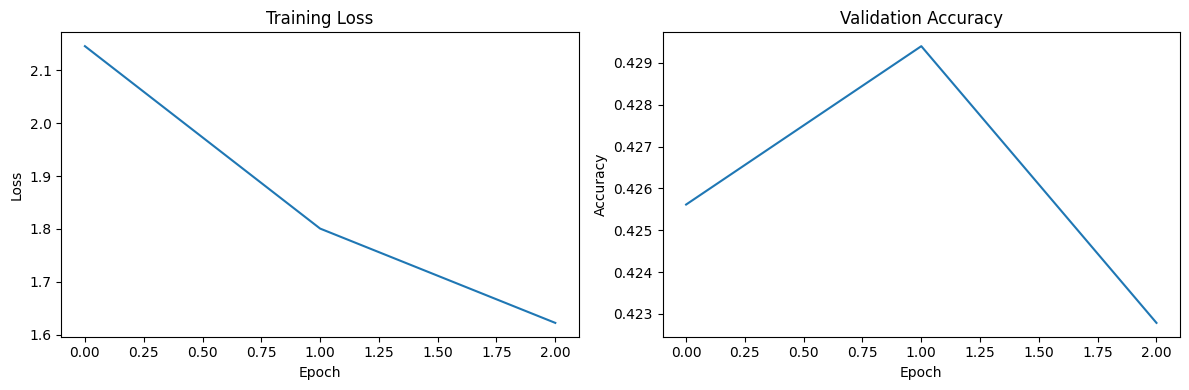

Analyzing sample conversation...

Emotion Analysis Results:
   chunk_id                                                            text     emotion  confidence
0         0                                   Hey, how are you doing today?   curiosity    0.325087
1         1                   I'm feeling great! Just got promoted at work!  admiration    0.406361
2         2                           That's amazing! I'm so happy for you!  admiration    0.611231
3         3    Thanks! But I'm also nervous about the new responsibilities.   gratitude    0.193661
4         4                 Don't worry, you'll do great. I believe in you!  admiration    0.391875
5         5   Actually, I'm starting to feel overwhelmed thinking about it.  excitement    0.277095
6         6  Hey, it's normal to feel that way. Take it one step at a time.    approval    0.498571
7         7                You're right. I feel much better now. Thank you!    approval    0.444424

Detected 1 emotion shifts:
  from_emoti

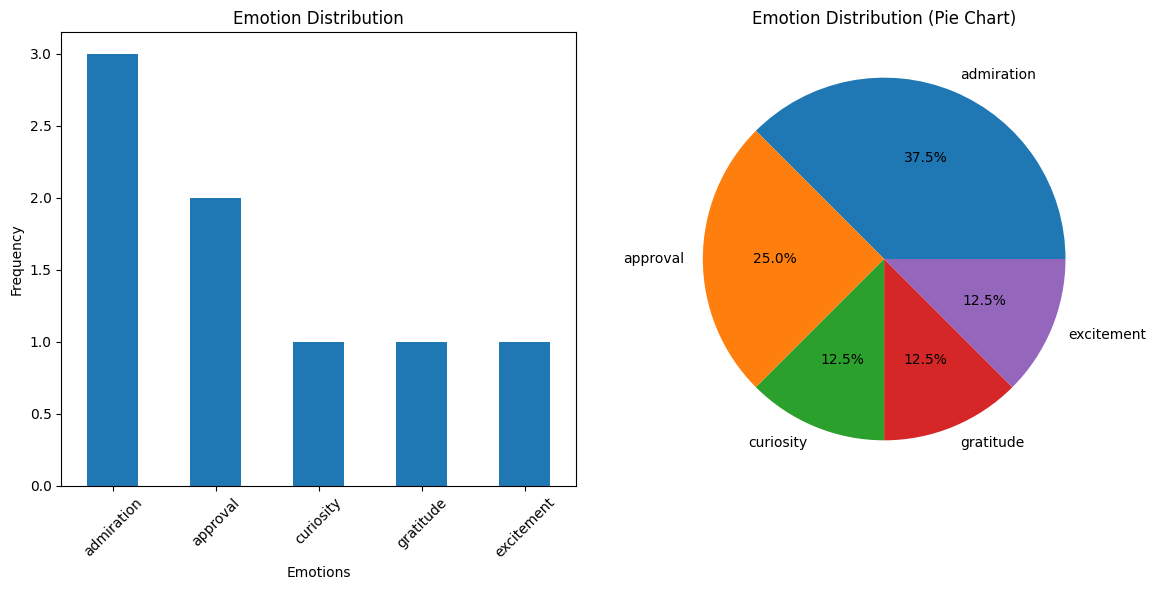

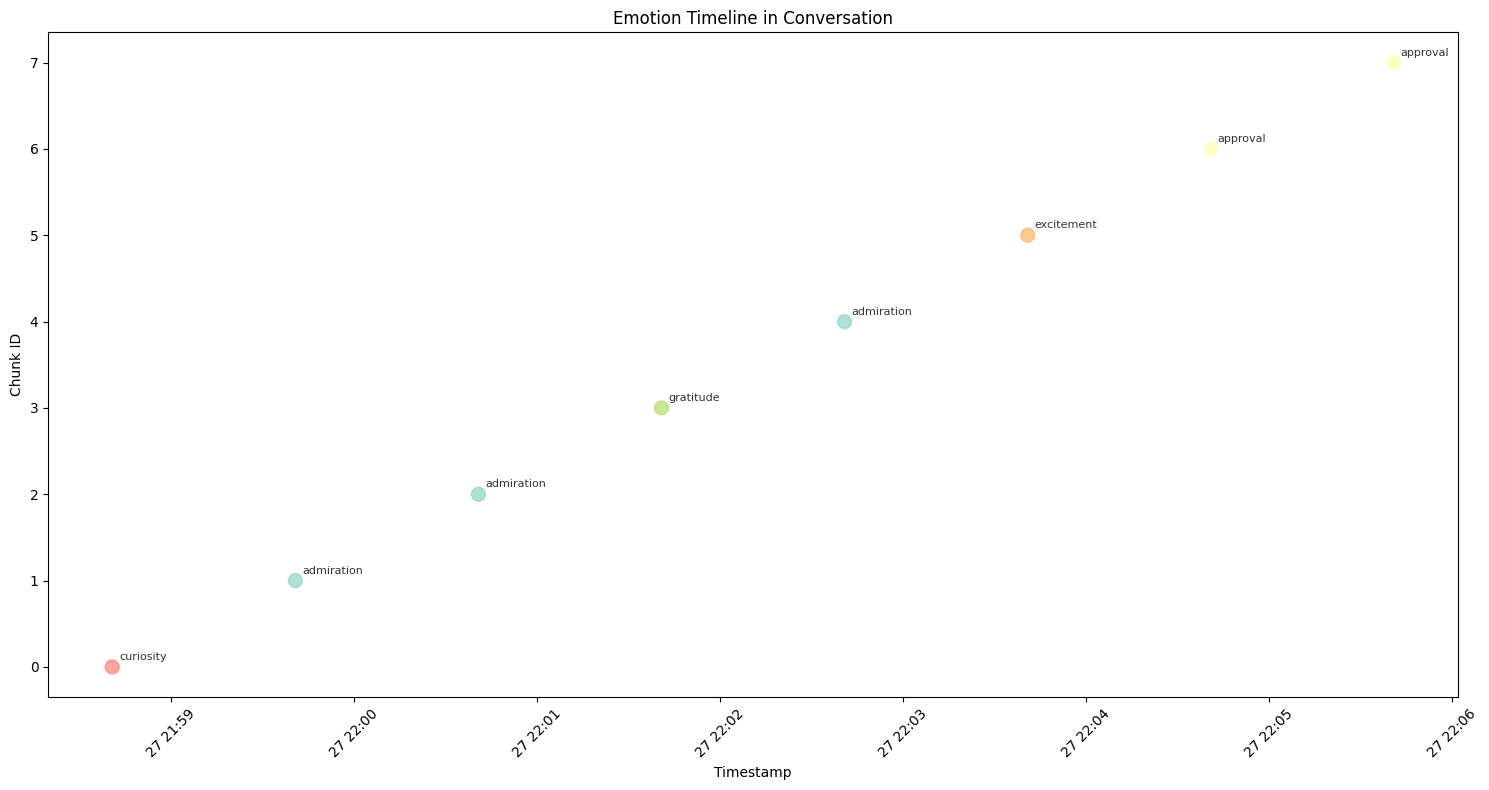

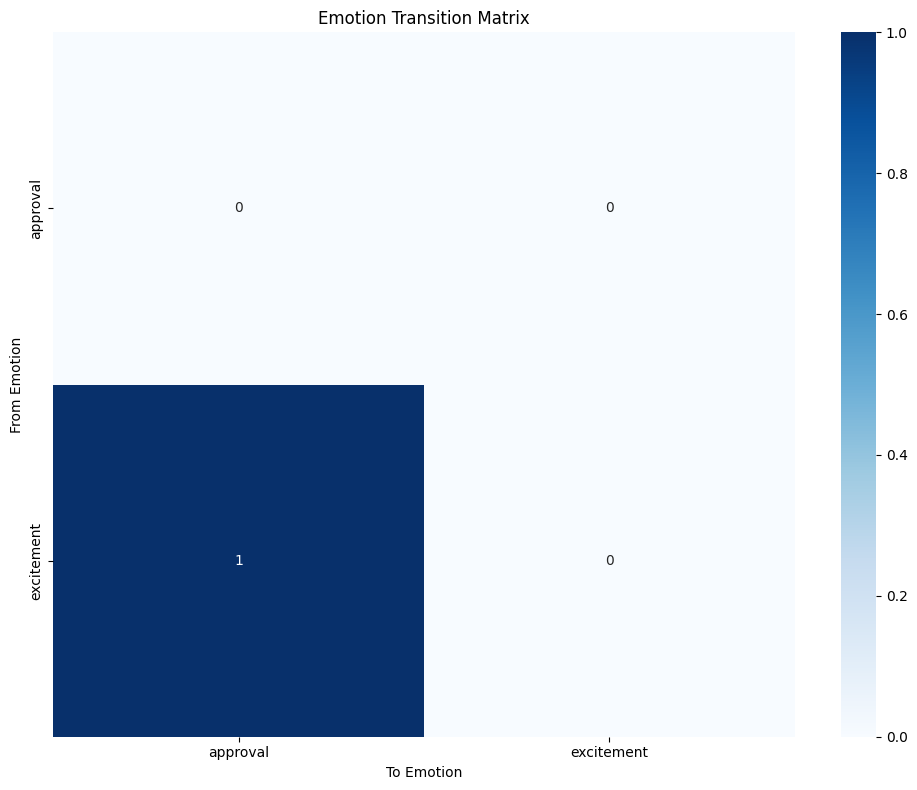


Analysis Completed Successfully.

Real-Time Analysis Example:
Message: I just started my new job today!
Detected Emotion: neutral (confidence: 0.441)
Message: The team seems really nice and welcoming.
Detected Emotion: admiration (confidence: 0.857)
Emotion Shift Detected: neutral → admiration (magnitude: 0.500)
Message: But I'm feeling a bit overwhelmed with all the information.
Detected Emotion: surprise (confidence: 0.133)
Emotion Shift Detected: admiration → surprise (magnitude: 0.000)
Message: I made a mistake on my first task and I'm embarrassed.
Detected Emotion: embarrassment (confidence: 0.522)
Emotion Shift Detected: surprise → embarrassment (magnitude: 1.000)
Message: My manager was understanding though, which made me feel better.
Detected Emotion: approval (confidence: 0.340)
Emotion Shift Detected: embarrassment → approval (magnitude: 0.750)

Conversation Summary:
1. [neutral] I just started my new job today!
2. [admiration] The team seems really nice and welcoming.
3. [s

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, logging)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="Some weights.*were not initialized.*")
logging.set_verbosity_error()
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS...")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA..")
else:
    device = torch.device("cpu")
    print("Using CPU...")
EMOTIONS = [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief','joy', 'love', 'nervousness', 'optimism', 'pride', 'realization',
    'relief', 'remorse', 'sadness', 'surprise', 'neutral']
CONFIG = {
    'model_name': 'bert-base-uncased',
    'max_length': 128,
    'batch_size': 16,
    'learning_rate': 2e-5,
    'epochs': 3,
    'warmup_steps': 500,
    'max_grad_norm': 1.0}
def load_goemotions_data(train_path, val_path, test_path):
    try:
        if train_path.endswith('.xlsx') or train_path.endswith('.xls'):
            train_df = pd.read_excel(train_path)
            val_df = pd.read_excel(val_path) 
            test_df = pd.read_excel(test_path)
        elif train_path.endswith('.tsv'):
            train_df = pd.read_csv(train_path, sep='\t')
            val_df = pd.read_csv(val_path, sep='\t')
            test_df = pd.read_csv(test_path, sep='\t')
        else:
            train_df = pd.read_csv(train_path)
            val_df = pd.read_csv(val_path)
            test_df = pd.read_csv(test_path)
        print(f"Train set: {len(train_df)} samples")
        print(f"Validation set: {len(val_df)} samples") 
        print(f"Test set: {len(test_df)} samples")
        print(f"\nDataset columns: {list(train_df.columns)}")
        print(f"Sample row:")
        print(train_df.head(1))
        return train_df, val_df, test_df
    except FileNotFoundError:
        print("Dataset files not found.")
        return None, None, None
    except Exception as e:
        print(f"Error loading dataset: {e}")
        return None, None, None
def preprocess_goemotions(df):
    processed_data = []
    emotion_cols = []
    for col in df.columns:
        if col.lower() in [emotion.lower() for emotion in EMOTIONS]:
            emotion_cols.append(col)    
    if not emotion_cols:
        for col in df.columns:
            if col not in ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear']:
                if df[col].dtype in ['int64', 'float64'] and df[col].nunique() <= 3: 
                    emotion_cols.append(col)
    print(f"Found emotion columns: {emotion_cols}")
    for _, row in df.iterrows():
        text = str(row['text']) if 'text' in row else str(row.iloc[0])  
        if emotion_cols:
            emotions = []
            for col in emotion_cols:
                if pd.notna(row[col]) and row[col] > 0:  
                    emotions.append(col)
            if emotions:
                main_emotion = emotions[0].lower()
                if main_emotion not in [e.lower() for e in EMOTIONS]:
                    main_emotion = 'neutral'
            else:
                main_emotion = 'neutral'
        else:
            main_emotion = 'neutral'        
        if main_emotion not in [e.lower() for e in EMOTIONS]:
            main_emotion = 'neutral'
        emotion_name = next((e for e in EMOTIONS if e.lower() == main_emotion.lower()), 'neutral')
        processed_data.append({
            'text': text,
            'emotion': emotion_name,
            'label': EMOTIONS.index(emotion_name)})
    return pd.DataFrame(processed_data)
def preprocess_goemotions_multilabel(df):
    processed_data = []    
    emotion_cols = []
    for col in df.columns:
        if col.lower() in [emotion.lower() for emotion in EMOTIONS]:
            emotion_cols.append(col)    
    if not emotion_cols:
        for col in df.columns:
            if col not in ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear']:
                if df[col].dtype in ['int64', 'float64'] and df[col].nunique() <= 3:
                    emotion_cols.append(col)    
    print(f"Multi-label emotion columns: {emotion_cols}")
    for _, row in df.iterrows():
        text = str(row['text']) if 'text' in row else str(row.iloc[0])
        labels = []
        for emotion in EMOTIONS:
            emotion_present = False
            for col in emotion_cols:
                if col.lower() == emotion.lower() and pd.notna(row[col]) and row[col] > 0:
                    emotion_present = True
                    break
            labels.append(1 if emotion_present else 0)
        processed_data.append({
            'text': text,
            'labels': labels})
    return pd.DataFrame(processed_data)
class EmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)}
class EmotionClassifier:
    def __init__(self, model_name, num_labels, device):
        self.device = device
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForSequenceClassification.from_pretrained(
            model_name, 
            num_labels=num_labels
        ).to(device)
    def prepare_data(self, train_df, val_df, batch_size=16):
        train_dataset = EmotionDataset(
            train_df['text'].values,
            train_df['label'].values,
            self.tokenizer,
            CONFIG['max_length'])
        val_dataset = EmotionDataset(
            val_df['text'].values,
            val_df['label'].values,
            self.tokenizer,
            CONFIG['max_length'])
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        return train_loader, val_loader
    def train(self, train_loader, val_loader, epochs=3, learning_rate=2e-5):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        total_steps = len(train_loader) * epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=CONFIG['warmup_steps'],
            num_training_steps=total_steps)
        train_losses = []
        val_accuracies = []
        for epoch in range(epochs):
            print(f"\nEpoch {epoch + 1}/{epochs}")            
            self.model.train()
            total_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels)
                loss = outputs.loss
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), CONFIG['max_grad_norm'])
                optimizer.step()
                scheduler.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            train_losses.append(avg_loss)
            val_acc = self.evaluate(val_loader)
            val_accuracies.append(val_acc)
            print(f"Average Loss: {avg_loss:.4f}")
            print(f"Validation Accuracy: {val_acc:.4f}")
        return train_losses, val_accuracies
    def evaluate(self, data_loader):
        self.model.eval()
        predictions = []
        true_labels = []
        with torch.no_grad():
            for batch in data_loader:
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)
                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask)
                preds = torch.argmax(outputs.logits, dim=1)
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())
        return accuracy_score(true_labels, predictions)
    def predict(self, text):
        self.model.eval()
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=CONFIG['max_length'],
            return_tensors='pt')
        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)
        with torch.no_grad():
            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
            predicted_class = torch.argmax(probabilities, dim=1).item()
        return {
            'emotion': EMOTIONS[predicted_class],
            'confidence': probabilities[0][predicted_class].item(),
            'all_probabilities': {EMOTIONS[i]: prob.item() for i, prob in enumerate(probabilities[0])}}
class ConversationAnalyzer:
    def __init__(self, emotion_classifier):
        self.classifier = emotion_classifier
    def chunk_conversation(self, messages, chunk_type='message'):
        chunks = []
        if chunk_type == 'message':
            for i, msg in enumerate(messages):
                chunks.append({
                    'chunk_id': i,
                    'text': msg['text'],
                    'timestamp': msg.get('timestamp', datetime.now() + timedelta(minutes=i)),
                    'user_id': msg.get('user_id', 'user1')})
        else: 
            chunk_id = 0
            for msg in messages:
                sentences = msg['text'].split('.')
                for sentence in sentences:
                    if sentence.strip():
                        chunks.append({
                            'chunk_id': chunk_id,
                            'text': sentence.strip(),
                            'timestamp': msg.get('timestamp', datetime.now() + timedelta(minutes=chunk_id)),
                            'user_id': msg.get('user_id', 'user1')})
                        chunk_id += 1
        return chunks
    def analyze_emotion_shifts(self, chunks):
        results = []
        for chunk in chunks:
            prediction = self.classifier.predict(chunk['text'])
            result = {
                'chunk_id': chunk['chunk_id'],
                'text': chunk['text'],
                'timestamp': chunk['timestamp'],
                'user_id': chunk['user_id'],
                'emotion': prediction['emotion'],
                'confidence': prediction['confidence'],
                'probabilities': prediction['all_probabilities']}
            results.append(result)
        return pd.DataFrame(results)
    def detect_shifts(self, emotion_df, shift_threshold=0.3):
        shifts = []
        for i in range(1, len(emotion_df)):
            prev_emotion = emotion_df.iloc[i-1]['emotion']
            curr_emotion = emotion_df.iloc[i]['emotion']
            if prev_emotion != curr_emotion:
                shift_magnitude = self.calculate_shift_magnitude(prev_emotion, curr_emotion)
                if shift_magnitude > shift_threshold:
                    shifts.append({
                        'from_chunk': i-1,
                        'to_chunk': i,
                        'from_emotion': prev_emotion,
                        'to_emotion': curr_emotion,
                        'shift_magnitude': shift_magnitude,
                        'timestamp': emotion_df.iloc[i]['timestamp']})
        return pd.DataFrame(shifts)
    def calculate_shift_magnitude(self, emotion1, emotion2):
        intensity_scores = {
            'neutral': 0, 'approval': 1, 'optimism': 2, 'joy': 3, 'amusement': 3,
            'love': 3, 'excitement': 3, 'admiration': 2, 'gratitude': 2, 'caring': 2,
            'pride': 2, 'relief': 2, 'curiosity': 1, 'confusion': 1, 'surprise': 2,
            'realization': 1, 'annoyance': -1, 'disappointment': -2, 'disapproval': -2,
            'anger': -3, 'sadness': -3, 'fear': -3, 'disgust': -3, 'grief': -4,
            'nervousness': -2, 'embarrassment': -2, 'remorse': -2, 'desire': 1}
        score1 = intensity_scores.get(emotion1, 0)
        score2 = intensity_scores.get(emotion2, 0)
        return abs(score2 - score1) / 4.0 
def plot_emotion_timeline(emotion_df):
    plt.figure(figsize=(15, 8))
    emotion_colors = plt.cm.Set3(np.linspace(0, 1, len(EMOTIONS)))
    color_map = {emotion: color for emotion, color in zip(EMOTIONS, emotion_colors)}
    colors = [color_map[emotion] for emotion in emotion_df['emotion']]
    plt.scatter(emotion_df['timestamp'], emotion_df['chunk_id'], 
               c=colors, s=100, alpha=0.7)
    for i, row in emotion_df.iterrows():
        plt.annotate(row['emotion'], 
                    (row['timestamp'], row['chunk_id']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.8)
    plt.xlabel('Timestamp')
    plt.ylabel('Chunk ID')
    plt.title('Emotion Timeline in Conversation')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
def plot_emotion_distribution(emotion_df):
    plt.figure(figsize=(12, 6))
    emotion_counts = emotion_df['emotion'].value_counts()
    plt.subplot(1, 2, 1)
    emotion_counts.plot(kind='bar')
    plt.title('Emotion Distribution')
    plt.xlabel('Emotions')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.subplot(1, 2, 2)
    plt.pie(emotion_counts.values, labels=emotion_counts.index, autopct='%1.1f%%')
    plt.title('Emotion Distribution (Pie Chart)')
    plt.tight_layout()
    plt.show()
def plot_emotion_transitions(shifts_df):
    if len(shifts_df) == 0:
        print("No emotion shifts detected.")
        return
    transitions = {}
    for _, row in shifts_df.iterrows():
        from_emotion = row['from_emotion']
        to_emotion = row['to_emotion']
        if from_emotion not in transitions:
            transitions[from_emotion] = {}
        if to_emotion not in transitions[from_emotion]:
            transitions[from_emotion][to_emotion] = 0
        transitions[from_emotion][to_emotion] += 1
    unique_emotions = list(set(shifts_df['from_emotion'].tolist() + shifts_df['to_emotion'].tolist()))
    matrix = np.zeros((len(unique_emotions), len(unique_emotions)))
    for i, from_emotion in enumerate(unique_emotions):
        for j, to_emotion in enumerate(unique_emotions):
            if from_emotion in transitions and to_emotion in transitions[from_emotion]:
                matrix[i][j] = transitions[from_emotion][to_emotion]
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt='g', 
                xticklabels=unique_emotions, yticklabels=unique_emotions,
                cmap='Blues')
    plt.title('Emotion Transition Matrix')
    plt.xlabel('To Emotion')
    plt.ylabel('From Emotion')
    plt.tight_layout()
    plt.show()
def main():    
    print("Loading dataset...")
    train_path = "goemotions_1.csv" 
    val_path = "goemotions_2.csv"    
    test_path = "goemotions_3.csv"   
    train_df, val_df, test_df = load_goemotions_data(train_path, val_path, test_path)
    if train_df is None:
        print("Dataset files not found. Creating sample data for demonstration purposes...")
        sample_data = {
            'text': ["I'm so happy about this!", "This is really annoying me", "I feel sad about what happened", "That's amazing news!", "I'm worried about the future", "This is just okay, nothing special",
                "I love spending time with family", "I'm angry about this situation", "I'm so grateful for your help", "This is confusing me", "I'm excited about tomorrow", "I feel embarrassed about what I did"],
            'emotion': ['joy', 'annoyance', 'sadness', 'excitement', 'fear', 'neutral', 'love', 'anger', 'gratitude', 'confusion', 'excitement', 'embarrassment'],
            'label': [EMOTIONS.index(emotion) for emotion in ['joy', 'annoyance', 'sadness', 'excitement', 'fear', 'neutral', 'love', 'anger', 'gratitude', 'confusion', 'excitement', 'embarrassment']]}
        train_df = pd.DataFrame(sample_data)
        val_df = train_df.copy()
        test_df = train_df.copy()
        print(f"Sample dataset created with {len(train_df)} samples.\n")
    else:
        print("\nPreprocessing the three data files...")
        train_df = preprocess_goemotions(train_df)
        val_df = preprocess_goemotions(val_df)
        test_df = preprocess_goemotions(test_df)
        print(f"\nProcessed datasets:")
        print(f"Train: {len(train_df)} samples")
        print(f"Val: {len(val_df)} samples") 
        print(f"Test: {len(test_df)} samples")
        print(f"\nEmotion distribution in training set:")
        print(train_df['emotion'].value_counts().head(10))
        print()
    print("Initializing BERT classifier...")
    classifier = EmotionClassifier(CONFIG['model_name'], len(EMOTIONS), device)    
    train_loader, val_loader = classifier.prepare_data(train_df, val_df, CONFIG['batch_size'])    
    train_model = input("Do you want to start training the model? (y/n): ").lower() == 'y'
    if train_model:
        print("Training model...")
        train_losses, val_accuracies = classifier.train(
            train_loader, val_loader, 
            CONFIG['epochs'], CONFIG['learning_rate'])
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.subplot(1, 2, 2)
        plt.plot(val_accuracies)
        plt.title('Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.tight_layout()
        plt.show()
    else:
        print("Skipping training, using pre-trained BERT base for demonstration...")
    print("Analyzing sample conversation...")
    sample_messages = [
        {"text": "Hey, how are you doing today?", "user_id": "user1"},
        {"text": "I'm feeling great! Just got promoted at work!", "user_id": "user2"},
        {"text": "That's amazing! I'm so happy for you!", "user_id": "user1"},
        {"text": "Thanks! But I'm also nervous about the new responsibilities.", "user_id": "user2"},
        {"text": "Don't worry, you'll do great. I believe in you!", "user_id": "user1"},
        {"text": "Actually, I'm starting to feel overwhelmed thinking about it.", "user_id": "user2"},
        {"text": "Hey, it's normal to feel that way. Take it one step at a time.", "user_id": "user1"},
        {"text": "You're right. I feel much better now. Thank you!", "user_id": "user2"}]    
    analyzer = ConversationAnalyzer(classifier)
    chunks = analyzer.chunk_conversation(sample_messages, chunk_type='message')
    emotion_results = analyzer.analyze_emotion_shifts(chunks)
    print("\nEmotion Analysis Results:")
    print(emotion_results[['chunk_id', 'text', 'emotion', 'confidence']].to_string())
    shifts = analyzer.detect_shifts(emotion_results)
    print(f"\nDetected {len(shifts)} emotion shifts:")
    if len(shifts) > 0:
        print(shifts[['from_emotion', 'to_emotion', 'shift_magnitude']].to_string())
    print("\nCreating visualizations...")
    plot_emotion_distribution(emotion_results)
    plot_emotion_timeline(emotion_results)
    if len(shifts) > 0:
        plot_emotion_transitions(shifts)
    print("\nAnalysis Completed Successfully.")
    return classifier, analyzer, emotion_results, shifts
if __name__ == "__main__":
    classifier, analyzer, results, shifts = main()
def analyze_new_message(classifier, analyzer, message_text, conversation_history=None):    
    prediction = classifier.predict(message_text)
    print(f"Message: {message_text}")
    print(f"Detected Emotion: {prediction['emotion']} (confidence: {prediction['confidence']:.3f})")
    if conversation_history is not None and len(conversation_history) > 0:
        last_emotion = conversation_history[-1]['emotion']
        current_emotion = prediction['emotion']        
        if last_emotion != current_emotion:
            shift_magnitude = analyzer.calculate_shift_magnitude(last_emotion, current_emotion)
            print(f"Emotion Shift Detected: {last_emotion} → {current_emotion} (magnitude: {shift_magnitude:.3f})")    
    return prediction
print("\nReal-Time Analysis Example:")
conversation = []
messages = [
    "I just started my new job today!",
    "The team seems really nice and welcoming.",
    "But I'm feeling a bit overwhelmed with all the information.",
    "I made a mistake on my first task and I'm embarrassed.",
    "My manager was understanding though, which made me feel better."]
for msg in messages:
    prediction = analyze_new_message(classifier, analyzer, msg, conversation)
    conversation.append({
        'text': msg,
        'emotion': prediction['emotion'],
        'confidence': prediction['confidence']})
print("\nConversation Summary:")
for i, entry in enumerate(conversation):
    print(f"{i+1}. [{entry['emotion']}] {entry['text']}")